# Example: web scraping the MLB box scores
---

## Outline:

### Identify a webpage you want to 'extract' or 'scrape' data from

For this example, we will be using box scores from the [Baseball Reference Site](https://www.baseball-reference.com/boxes/). For the sake of clarity, a box score is defined as a box containing the number of runs each team scored during a game, as well as the winning pitcher, losing pitcher, and (where applicable) the pitcher who got the 'save.'

### Examine the HTML structure of the webpage

The easiest means for accomplishing this is to inspect the webpage's source. In most browsers, right-click somewhere on the page and click the 'Inspect Element' option. This should open a small window on your browser that list the HTML code. More importantly, this window is interactive; that is, when you highlight sections of the HTML code, the accompanying elements of the webpage are highlighted. 

For this task I am interested in data contained within: `<div id="content" class="index" role="main">`, which contains ALL the webpage's content outside of the header and footer (which are always present).

The box scores themselves are listed as individial `<division>` tags within the over-arching `<div id="content" class="index" role="main">` tag. This is a common construct in HTML organization. Notice that all of the individual box scores are contained within a `<div class="game summaries">` tag. 

Each box score is defined as its own `<div class="game_summary nohover">` tag. These divisions are what contain the data we want to extract! If you are in to programming, you are probably already thinking about how you can loop through each of these divisions and extract the relevant data. But first... 

---
## Python code

In [31]:
# Import the BeautifulSoup and requests modules
from bs4 import BeautifulSoup
import requests

url = "https://www.baseball-reference.com/boxes/"
r = requests.get(url)
data = r.content # Grab all of the html
soup = BeautifulSoup(data, "html5lib") # Parse the code into HTML5 format

### Loop through HTML data and grab each box score

In [32]:
allgames=soup.find_all("div", class_="game_summary nohover") # Python's find_all command
dateofgames = soup.find("div", class_="prevnext").find("span", class_="button2").text # Grab today's date for title purposes

### Create a bunch of dictionary [class:value] pairs for each piece of data listed in a box score

In [33]:
l=[] # Create empty list to fill with dictionaries
for matchup in allgames:
    d={}
    tr_list=matchup.find_all("tr",{"class":["winner","loser"]})
    td_list=matchup.find_all("td",class_="right")
    pitchers=matchup.find_all("tbody")[1].find_all("td")
    d["Away Team"]=tr_list[0].a.text
    d["Away Runs"]=td_list[0].text
    d["Home Team"]=tr_list[1].a.text
    d["Home Runs"]=td_list[2].text
    if len(pitchers) < 5:
        d["W Pitcher"]=pitchers[1].text
        d["L Pitcher"]=pitchers[3].text
        d["S Pitcher"]=None
    else:
        d["W Pitcher"]=pitchers[1].text
        d["L Pitcher"]=pitchers[3].text
        d["S Pitcher"]=pitchers[5].text
    l.append(d)

### If you want to see the structure of the list of dictionary values you just created; uncomment and run the line below

In [34]:
#l

### Take advantage of Python's Pandas module to create a DataFrame using your newly populated list

In [35]:
import pandas
df=pandas.DataFrame(l)

### If you want to see the structure of the DataFrame you just created; uncomment and run the line below

In [36]:
#df

### Pandas DataFrames can handle a mix of data types (e.g. numeric, string, object, etc.). Pandas accomplishes this by assigning the columns of a heterogeneous DataFrame the data type of 'object'
- You should always check what data type all of your columns contain by running `df.dtypes`

In [37]:
df.dtypes

Away Runs    object
Away Team    object
Home Runs    object
Home Team    object
L Pitcher    object
S Pitcher    object
W Pitcher    object
dtype: object

### However, we want columns containing numbers to be of dtype:numeric in order to plot the values in graphs

In [38]:
# Condition to data to correct data types:
df[['Away Runs','Home Runs']]=df[['Away Runs','Home Runs']].apply(pandas.to_numeric)

### Import Python's plotting module: matplotlib and Python's numeric module: numpy

In [39]:
# Import plotting tools
import matplotlib.pyplot as plt
import numpy as np

# Tell matplotlib to show the graph in your notebook rather than open a new window
%matplotlib inline 

---
## Next step: create bar charts for each box score and plot them as subplots

- ### Plotting always involves a lot of formatting... for this section the Matplotlib homepage and stackoverflow.com are your friend!
- ### There are many different ways you could approach how to plot your data. I chose bar charts as they are a quick way to get a visual idea of which team won the game and whether it was a close game or not.

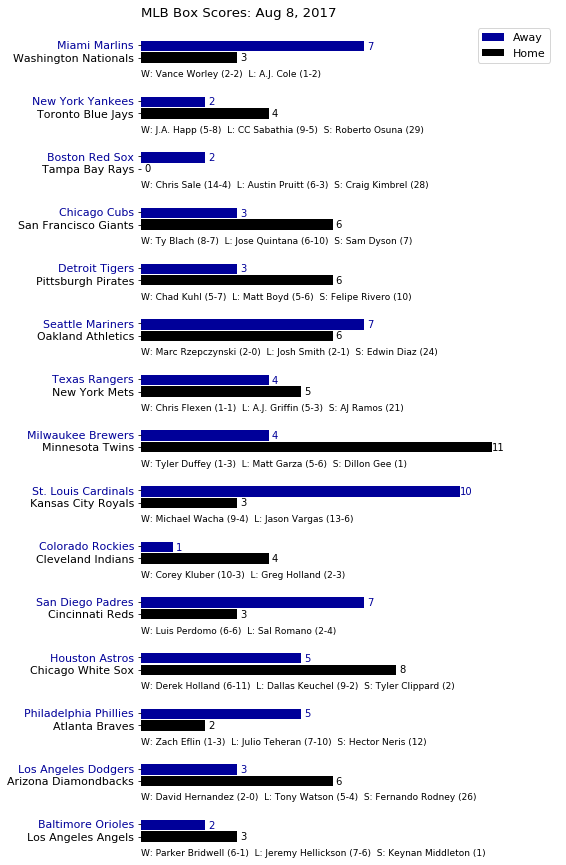

In [42]:
# 1.0 - Extract data from dataframe
aruns = df.loc[:,"Away Runs"]
ateam = df.loc[:,"Away Team"]
hruns = df.loc[:,"Home Runs"]
hteam = df.loc[:,"Home Team"]
wpitc = df.loc[:,"W Pitcher"]
lpitc = df.loc[:,"L Pitcher"]
spitc = df.loc[:,"S Pitcher"]

# 1.1 Define variables for barchart
barwidth = 1.5
ayy = np.arange(len(df))*8
ylocations = np.sort(np.hstack((ayy,ayy+barwidth+0.2*barwidth)))
allteams = []
for i in range(len(ateam)):
    allteams.append(hteam[i])
    allteams.append(ateam[i])
opacity = 1.0
hcolor = '#000000'
acolor = '#000099'

# 1.2 Create plot
f, ax = plt.subplots(figsize=(8,12))
rects1 = plt.barh(ayy, hruns, barwidth, color=hcolor, alpha=opacity, label="Home")
rects2 = plt.barh(ayy+barwidth+0.1*barwidth, aruns, barwidth, color=acolor, alpha=opacity, label="Away")

# 1.3 Modify plot details
#ax.set_facecolor('#E8E8E8')
ax.set_ylim([-1,ayy[-1]+5])  # Define scale
ax.set_xlim([0,(df[["Away Runs","Home Runs"]].max()).max()+2])
plt.yticks(ylocations, allteams)  # Change x-labels and ticks
plt.tick_params(axis='y',which='major',left='on',right='off',labelleft='on')
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.rcParams.update({'font.size': 11})

count = 0
for ytick in ax.get_yticklabels():
    if count % 2 == 0:
        ytick.set_color(hcolor)
        count = count + 1
    else:
        ytick.set_color(acolor)
        count = count + 1


# 1.4 Auto label the bars at their tops
def autolabel(rects,color):
    for rect in rects:
        width = rect.get_width()
        plt.text(width+0.2, rect.get_y(),
                    '%d' % int(width),
                    ha='center', va='bottom', fontsize = 10, color = color)
        
# 1.5 Include the winning, losing, and save (if applicable) pitcher info below the runs
def pitcherinfo(wp,lp,sv,bot_rects):
    for wpitc,lpitc,spitc,rect in zip(wp,lp,sv,bot_rects):
        if not spitc:
            plt.text(0,rect.get_y()-2,"W: "+wpitc+"  L: "+lpitc, fontsize=9)
        else:
            plt.text(0,rect.get_y()-2,"W: "+wpitc+"  L: "+lpitc+"  S: "+spitc, fontsize=9)
        
        
autolabel(rects1, hcolor)
autolabel(rects2, acolor)
pitcherinfo(wpitc,lpitc,spitc,rects1)

# 1.6 Execute plot
plt.legend((rects2,rects1),('Away','Home'),loc=0)
plt.title("MLB Box Scores: "+dateofgames,loc = 'left')
plt.tight_layout()
